# Pre vs post baselines comparisons and prepregnancy dynamics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm

from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")

matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

# General functions and settings

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

wedgeprops = {'width':0.7,"edgecolor" : "k",'linewidth': 0.2,'antialiased': True}

# Loading the dataset
### Metadata infotmation
* 'metadata' - Tests names in various forms, divison to groups and units
* 'labnorm'  - Referenence values for tests

We consider only tests with reference values and remove tests with missing bins (86 tests)

In [3]:
# Loading the dataset into 'dfs'
path          = '../Clalit Data/pregnancy.1w/'
files         = [file for file in os.listdir(path)]
all_tests     = [file.split('.')[0] for file in files]
dfs           = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# We removed duplicate tests
# Duplicate tests include K:POTASSIUM_BLOOD, Na:SODIUM_BLOOD, RDW:RDW_CV
remove        = ['POTASSIUM_BLOOD','SODIUM_BLOOD','RDW_CV']
all_tests     = np.unique(list(set(all_tests)- set(remove)))

groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0).drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')

ndf           = pd.DataFrame([dfs[test]['n'] for test in all_tests],index=all_tests).fillna(0).astype(int)
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)
bias_df       = pd.read_csv('../Files/bias_score_070523.csv',index_col=0)
bias_tests    = set(bias_df.loc[bias_df.sum(axis=1)<3].index)
removed_tests = set(list(set(all_tests) - set(labnorm_tests)) + list(bias_tests))
tests         = sorted(list(set(labnorm_tests).intersection(all_tests) - set(removed_tests)))
len(tests)

In [4]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'])
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_value_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_SDS_stats(test):
    tdf      = get_value_stats(test)
    if test in labnorm_tests:
        ref      = get_age_matched_reference(test)
        ref_mean = ref['mean'] 
        ref_sd   = ref['sd']
        v        = (tdf['value'] - ref_mean) / ref_sd
        e        = tdf['error'] / ref_sd
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_test_data(test):
    return {'mean'             :get_value_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'SDS'              :get_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

def plot_test(test,stat,ax,c='k',focus_background=True,remove_background=False,n_title=False,period=[-60,80],xticks_interval=20):
    
    try:
        x,v,e,n = get_stats_from_dataset(test,stat,period=period)
        ax.errorbar(x,v,e,c=c,lw=1,fmt='-o',markersize=1,zorder=-3)   
        # choose different setting based on statistic type
        if stat == 'mean':
            ylabel             = 'Mean Test Value'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'value_at_quantile':
            ylabel             = 'Value At Mean Quantile'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'quantile':
            ylabel             = 'Mean Quantile'
            ylm                = [0,1]
            add_ref_background = False
            ax.axhline(0.5,lw=1,ls='--',zorder=-3,c='k')

        if remove_background:
            add_ref_background = False
            
        # title    
        title     = metadata.loc[test]['Nice name']
        if n_title:
            title = title +', ' + 'n = ' + fmt_num(np.sum(n))    

        # plot the background
        if add_ref_background:
            if test in np.unique(labnorm_tests):
                
                ref = get_age_matched_reference(test)
                ax.axhspan(ref['quantile'](0.03),ref['quantile'](0.97),zorder=-4,alpha=0.1,color='#86bf91')
                ax.axhspan(ref['quantile'](0.10),ref['quantile'](0.90),zorder=-4,alpha=0.1,color='#86bf91')
                ax.axhspan(ref['quantile'](0.15),ref['quantile'](0.85),zorder=-4,alpha=0.2,color='#86bf91')
                ax.axhspan(ref['quantile'](0.25),ref['quantile'](0.75),zorder=-4,alpha=0.3,color='#86bf91')
                ax.axhspan(ref['quantile'](0.35),ref['quantile'](0.65),zorder=-4,alpha=0.5,color='#86bf91')
                md = ref['quantile'](0.5)
                
#                 ax.axhline(temp['q50'],lw=1,zorder=-3,c='gray')
                if focus_background:
                    ylm = list(ax.get_ylim())
                    if np.min(v) < ylm[0]:
                        ylm[0] = np.min(v)*0.99
                  
                else:
                    if ylm[0] > md:
                        ylm[0] = md*0.99
                    if ylm[1] < md:
                        ylm[1] = md*1.01     
                    ylm = [ylm[0]- (ylm[1] - ylm[0])*0.1,ylm[1]+ (ylm[1] - ylm[0])*0.1]
            else:
                ax.set_facecolor('white')    

        # edit axis labels
        ax.set_xticks(np.arange(period[0],period[1],xticks_interval))
        ax.set_xlim(period)
        ax.set_xlabel('Weeks postpartum')
        ax.set_ylabel(ylabel)
        ax.set_ylim([ylm[0],ylm[1]])
    except:
        ax.set_facecolor('white')    
        title     = metadata.loc[test]['Nice name']
        
    ax.set_title(title,fontsize=10)    
    remove_top_right_frame([ax])

In [5]:
data = {test:get_test_data(test) for test in tqdm(tests)}

  0%|          | 0/78 [00:00<?, ?it/s]

## Preconception dyanmics

#### To analyze preconception dyanamics, we perfrome a linear regression over the preconception period

In [6]:
def lin_reg(xdat,a,b):
    return a + b*xdat

summery = []
for i,test in enumerate(tests):
    
    tdf   = get_test_data(test)['quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    summery.append([zscore,*popt])

reg_res                    = pd.DataFrame(summery,index=tests,columns=['Zscore','intercept','coeff'])
reg_res['abs_zscore']      = np.abs(reg_res['Zscore'])
reg_res['pvalue']          = stats.norm.sf(reg_res['abs_zscore']).flat[:]
reg_res['pvalue_adjusted'] = fdrcorrection(reg_res['pvalue'])[1]
reg_res['FDR']             = reg_res['pvalue_adjusted'] < 0.05
reg_res['Name']            = [metadata.loc[test]['Nice name'] for test in reg_res.index]
reg_res['significant']     = (np.abs(reg_res['coeff']) > 0.001) & reg_res['FDR']
reg_res['coeff']           = reg_res['coeff']*100

table1 = reg_res.loc[reg_res['significant']][['Name','coeff','pvalue_adjusted']].sort_values(by='Name').copy()
table1 = table1.round(decimals=3)
table1 = table1.loc[np.abs(table1['coeff']) > 0.1]

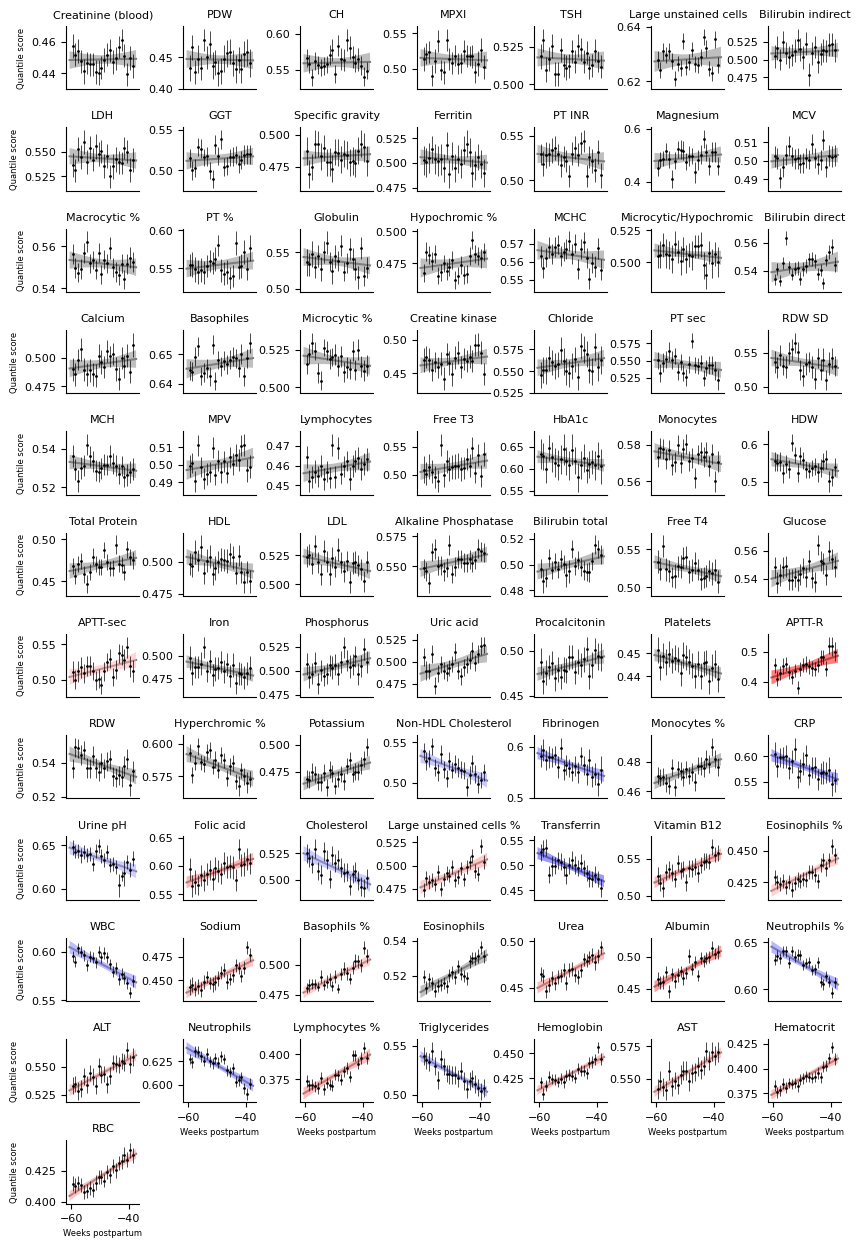

In [7]:
minima = -reg_res.loc[reg_res['significant']]['coeff'].max()
maxima = reg_res.loc[reg_res['significant']]['coeff'].max()
norm   = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

plt.figure(figsize=(10,np.ceil(len(tests))/5))
for i,test in enumerate(reg_res.sort_values(by='abs_zscore').index):
    ax    = plt.subplot(int(np.ceil(len(tests)/7)),7,i+1)
    tdf   = get_test_data(test)['quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    ypred = lin_reg(xdat,*popt)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)

    y_bar = np.mean(ypred)
    R2    = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    ax.errorbar(xdat, ydat,yerr,fmt='o',c='k',markersize=1,lw=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = lin_reg(x_fitted,*popt)
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))
    
    if reg_res['significant'].loc[test]:
        col = mapper.to_rgba(reg_res['coeff'].loc[test]) 
        ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c='k',zorder=0,alpha=0.5)
        ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=col,alpha=0.5, zorder=1)  
    else:
        ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c='k',zorder=0,alpha=0.5)
        ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='gray',alpha=0.5, zorder=1)  

    ax.set_title(metadata.loc[test]['Nice name'])
    ax.set_xlabel('Weeks postpartum',fontsize=6)
    ax.set_ylabel('Quantile score',fontsize=6)
    
    remove_top_right_frame([ax])
    if i<len(tests)-7:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,7) != 0:
        ax.set_ylabel('')
    
plt.subplots_adjust(hspace=0.6,wspace=0.6); 
plt.savefig('preconception_dynamics_allsubplots.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

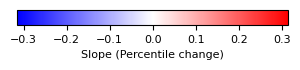

In [8]:
plt.figure(figsize=(3.5,0.2))
axcbar = plt.subplot(111)
cb     = mpl.colorbar.ColorbarBase(axcbar,cmap='bwr',norm=norm,orientation='horizontal',label='Slope (Percentile change)')
plt.savefig('preconception_dynamics_cbar.pdf',bbox_inches = 'tight',pad_inches=0.1);     

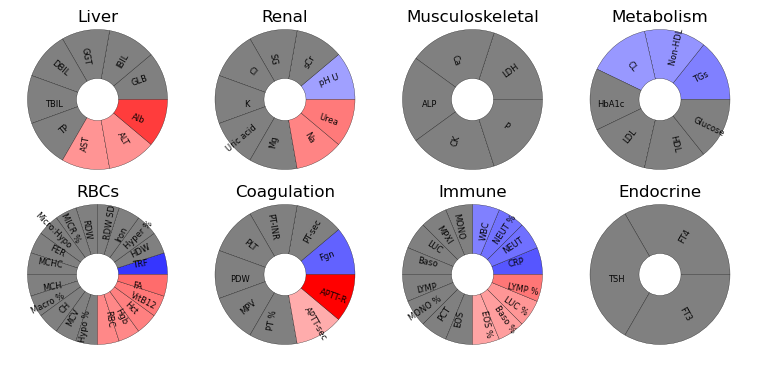

In [9]:
plt.figure(figsize=(7.5,3.5))
for i in range(len(groups)):
    ax     = plt.subplot(2,4,i+1)
    tdf    = reg_res.loc[set(tests).intersection(metadata.loc[metadata.Group == groups[i]].index)].copy().sort_values(by='coeff')
    sizes  = np.ones(len(tdf)).astype(int)
    labels = [metadata.loc[test]['Short name'] for test in list(tdf.index)]
    colors = [mapper.to_rgba(tdf.iloc[j]['coeff']) if tdf.iloc[j]['significant'] else 'gray' for j in range(len(tdf))]
    pie    = ax.pie(sizes, colors=colors,labels=labels,labeldistance=0.5,textprops=dict(color="k",size=6,alpha=0.95),rotatelabels =True,wedgeprops = wedgeprops)
    ax.set_title(groups[i],fontsize=12,y=0.9)
    
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)  
plt.savefig('preconception_dynamics_pies.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

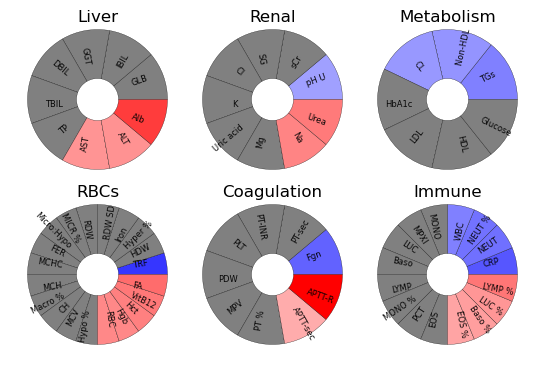

In [10]:
plt.figure(figsize=(7*3/4,3.5))
for j,i in enumerate([0,1,3,4,5,6]):
    ax     = plt.subplot(2,3,j+1)
    tdf    = reg_res.loc[set(tests).intersection(metadata.loc[metadata.Group == groups[i]].index)].copy().sort_values(by='coeff')
    sizes  = np.ones(len(tdf)).astype(int)
    labels = [metadata.loc[test]['Short name'] for test in list(tdf.index)]
    colors = [mapper.to_rgba(tdf.iloc[j]['coeff']) if tdf.iloc[j]['significant'] else 'gray' for j in range(len(tdf))]
    pie    = ax.pie(sizes, colors=colors,labels=labels,labeldistance=0.5,textprops=dict(color="k",size=6,alpha=0.95),rotatelabels =True,wedgeprops = wedgeprops)
    ax.set_title(groups[i],fontsize=12,y=0.9)
    
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)  
plt.savefig('preconception_dynamics_pies_6pies.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

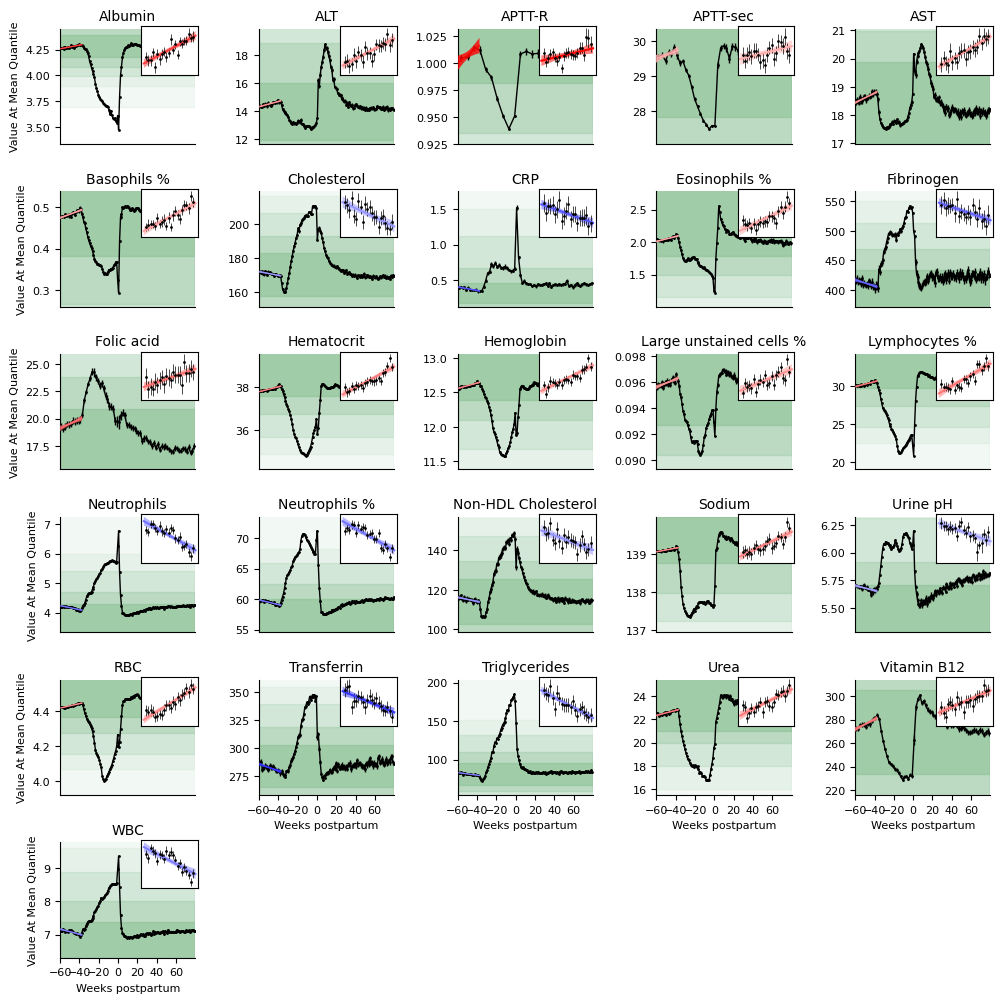

In [11]:
plt.figure(figsize=(10,np.ceil(len(tests))/3))
for i,test in enumerate(reg_res.loc[reg_res['significant']].index):
    axi   = plt.subplot(int(np.ceil(len(tests)/5)),5,i+1)
    ax    = axi.inset_axes([0.6, 0.6, 0.42, 0.42])
    plot_test(test,'value_at_quantile',axi,focus_background=False) 
    
    tdf   = get_test_data(test)['value_at_quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    ypred = lin_reg(xdat,*popt)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)

    y_bar = np.mean(ypred)
    R2    = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    ax.errorbar(xdat, ydat,yerr,fmt='o',c='k',markersize=1,lw=0.5)
    xlim     = ax.get_xlim()
    ylim     = ax.get_ylim()
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = lin_reg(x_fitted,*popt)
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))
    
    if reg_res['pvalue_adjusted'].loc[test] < 0.05:
        col = mapper.to_rgba(reg_res['coeff'].loc[test]) 
        ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c=col)
        axi.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),lw=1,c=col)

        ax. fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=col,alpha=0.5, zorder=1)  
        axi.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=col,alpha=0.8, zorder=6)   
    else:
        ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='gray',alpha=0.8, zorder=6)  

    ax.set_xticks([])
    ax.set_yticks([])
    
    if i<len(reg_res.loc[reg_res['significant']].index)-5:
        axi.set_xticks([])
        axi.set_xlabel('')
    if np.mod(i,5) != 0:
        axi.set_ylabel('')
    
plt.tight_layout();
plt.savefig('preconception_dynamics_significant_subplots.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

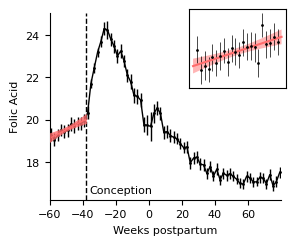

In [12]:
plt.figure(figsize=(3,2.5))
for i,test in enumerate(['FOLIC_ACID']):
    axi   = plt.subplot(111)
    ax    = axi.inset_axes([0.6, 0.6, 0.42, 0.42])
    plot_test(test,'value_at_quantile',axi,focus_background=False,remove_background=True) 
    
    tdf   = get_test_data(test)['value_at_quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    ypred = lin_reg(xdat,*popt)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)

    y_bar = np.mean(ypred)
    R2    = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    ax.errorbar(xdat, ydat,yerr,fmt='o',c='k',markersize=1,lw=0.5)
    xlim     = ax.get_xlim()
    ylim     = ax.get_ylim()
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = lin_reg(x_fitted,*popt)
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))
    
    if reg_res['pvalue_adjusted'].loc[test] < 0.05:
        col = mapper.to_rgba(reg_res['coeff'].loc[test]) 
        ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c=col)
        axi.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),lw=1,c=col)

        ax. fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=col,alpha=0.5, zorder=1)  
        axi.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=col,alpha=0.8, zorder=6)   
    else:
        ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='gray',alpha=0.8, zorder=6)  

    ax.set_xticks([])
    ax.set_yticks([])
    axi.axvline(x=-38,c='k',ls='--',lw=1)
    axi.set_title('')
    axi.set_ylabel('Folic Acid')
    axi.annotate('Conception',(-36,16.5),fontsize=8)
    
plt.tight_layout();
plt.savefig('folic_acid.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()